In [1]:
import tensorflow
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
audio_dataset_path =r"E:\Music_classification\Data\genres_original"
metadata = pd.read_csv(r'E:\Final 2Dataset2\metadata_clear.csv')
metadata = pd.read_csv(r'E:\Music_classification\Data\features_30_sec.csv')
metadata.head(5)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
# function to get mfcc from a file
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast',duration=29)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features=mfccs_features.T

    return mfccs_scaled_features

In [ ]:
file_name="E:\Music_classification\Data\genres_original\\rock\\rock.00016.wav"
file_name="E:\Music_classification\Data\genres_original\\blues\\blues.00016.wav"
ps=features_extractor(file_name)
ps.shape

In [4]:
from tqdm import tqdm
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    #file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["filename"]).partition(".")[0],"/"+str(row["filename"]))
    final_class_labels = row["label"]
    file_name = os.path.join(os.path.abspath(audio_dataset_path),final_class_labels+"\\",str(row["filename"]))
    #print(file_name)
    data = features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

1000it [00:27, 36.71it/s]


In [5]:
dataset = extracted_features
random.shuffle(dataset)

train = dataset[:750] # select first 750 samples
test = dataset[850:] # select everything but first 850 samples
val = dataset[750:850]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)
X_val, y_val = zip(*val)

In [ ]:
np.array(X_train).shape

In [6]:
# Reshape for CNN input
X_train = np.array([x.reshape( (1249, 40, 1) ) for x in X_train])
X_test = np.array([x.reshape( (1249, 40, 1) ) for x in X_test])
X_val = np.array([x.reshape( (1249, 40, 1) ) for x in X_val])

In [7]:
# One-Hot encoding for classes
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y_train = tensorflow.keras.utils.to_categorical(labelencoder.fit_transform(y_train))
y_test = np.array(tensorflow.keras.utils.to_categorical(labelencoder.fit_transform(y_test)))
y_val = np.array(tensorflow.keras.utils.to_categorical(labelencoder.fit_transform(y_val)))

In [ ]:
X_train.shape

In [ ]:
y_val.shape

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    
    fig, axs = plt.subplots(2,constrained_layout=True)

    #create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    #create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [9]:
model=Sequential()
input_shape=(1249, 40, 1)

model.add(Conv2D(32, (3,3), padding='valid', input_shape=input_shape))
model.add(MaxPooling2D(2,padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(128, (3,3), padding='valid'))
model.add(MaxPooling2D(2,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
                                              
model.add(Conv2D(128, (3,3), padding='valid'))
model.add(MaxPooling2D(2, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Epoch 1/100
12/12 [==============================] - 5s 255ms/step - loss: 2.6613 - accuracy: 0.1373 - val_loss: 2.2449 - val_accuracy: 0.1000

Epoch 00001: val_loss improved from inf to 2.24494, saving model to saved_models\audio_classification.hdf5
Epoch 2/100
12/12 [==============================] - 2s 183ms/step - loss: 2.0846 - accuracy: 0.2440 - val_loss: 2.0133 - val_accuracy: 0.2733

Epoch 00002: val_loss improved from 2.24494 to 2.01334, saving model to saved_models\audio_classification.hdf5
Epoch 3/100
12/12 [==============================] - 2s 182ms/step - loss: 1.7544 - accuracy: 0.3640 - val_loss: 1.7431 - val_accuracy: 0.3133

Epoch 00003: val_loss improved from 2.01334 to 1.74312, saving model to saved_models\audio_classification.hdf5
Epoch 4/100
12/12 [==============================] - 2s 182ms/step - loss: 1.6144 - accuracy: 0.3973 - val_loss: 1.6683 - val_accuracy: 0.3867

Epoch 00004: val_loss improved from 1.74312 to 1.66825, saving model to saved_models\audio_clas

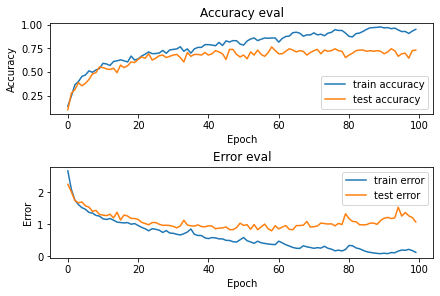

5/5 [==============================] - 0s 27ms/step - loss: 1.0737 - accuracy: 0.7333
Test loss: 1.0737437009811401
Test accuracy: 0.7333333492279053
Training completed in time:  0:03:43.038998


In [10]:
#optimizer = tensorflow.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer="adam")

## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

num_epochs = 100
num_batch_size = 64

keras_callbacks = [
	 EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.01),
	 ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True, mode='min')
]


start = datetime.now()

#history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=keras_callbacks, verbose=1)
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True, mode='min')
], verbose=1)
plot_history(history)

score = model.evaluate(
	X_test,
	y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

duration = datetime.now() - start
print("Training completed in time: ", duration)

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

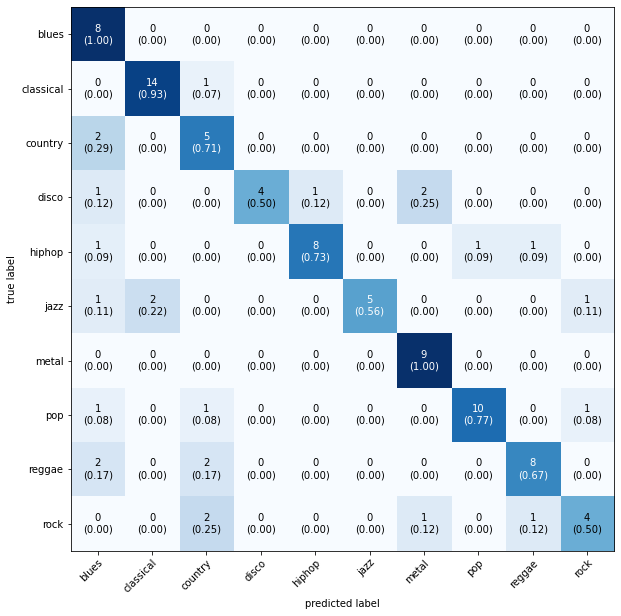

In [11]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_pred = (model.predict(X_val) > 0.5).astype("int32")
class_names=["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

mat=confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(conf_mat=mat,class_names=class_names,show_normed=True,figsize=(10,10))

In [12]:
score = model.evaluate(
	X_val,
	y_val)

print('val loss:', score[0])
print('val accuracy:', score[1])

4/4 [==============================] - 0s 23ms/step - loss: 0.8584 - accuracy: 0.7800
val loss: 0.8584178686141968
val accuracy: 0.7799999713897705
